In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, func
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# Reflect the tables into classes
Base = automap_base()

# Reflect the tables from the database
Base.prepare(engine, reflect=True)




C:\Users\abdul\AppData\Local\Temp\ipykernel_18868\767353529.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print("Classes found:")
for table_name, cls in Base.classes.items():
    print(f"- Table: {table_name}, Class: {cls.__name__}")

Classes found:
- Table: station, Class: station
- Table: measurement, Class: measurement


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [8]:

# Create our session (link) from Python to the DB
Session = sessionmaker(bind=engine)
session = Session()


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latest_date = session.query(func.max(Measurement.date)).scalar()
print(latest_date)

2017-08-23


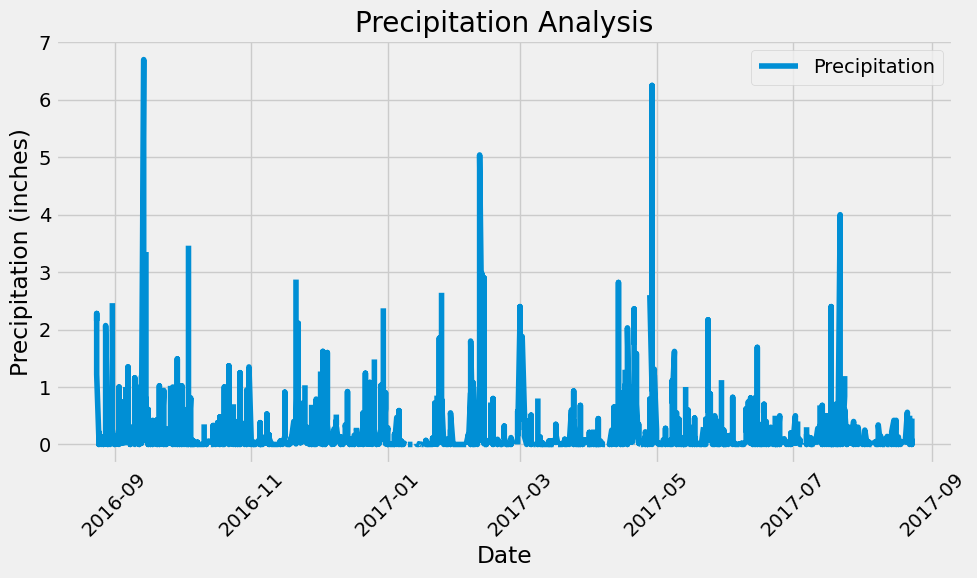

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# the format of the date string
date_format = "%Y-%m-%d"
    
# fetching the date one year ago
one_year_ago = datetime.strptime(latest_date, date_format) - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp) \
                 .filter(Measurement.date >= one_year_ago) \
                 .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime
df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Precipitation'], label='Precipitation')
plt.title('Precipitation Analysis')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df.describe()

print(summary_stats)


       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print("Total number of stations:", total_stations)

Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)) \
                              .group_by(Measurement.station) \
                              .order_by(func.count(Measurement.station).desc()) \
                              .all()

# Print the stations and their observation counts in descending order
for station, count in most_active_stations:
    print(f"Station: {station}, Observation Count: {count}")



Station: USC00519281, Observation Count: 2772
Station: USC00519397, Observation Count: 2724
Station: USC00513117, Observation Count: 2709
Station: USC00519523, Observation Count: 2669
Station: USC00516128, Observation Count: 2612
Station: USC00514830, Observation Count: 2202
Station: USC00511918, Observation Count: 1979
Station: USC00517948, Observation Count: 1372
Station: USC00518838, Observation Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
result = session.query(func.min(Measurement.tobs).label('min_temp'),
                           func.max(Measurement.tobs).label('max_temp'),
                           func.avg(Measurement.tobs).label('avg_temp')) \
                   .filter(Measurement.station == most_active_stations[0][0]) \
                   .first()

print("Minimum Temperature:", result.min_temp)
print("Maximum Temperature:", result.max_temp)
print("Average Temperature:", result.avg_temp)


Minimum Temperature: 54.0
Maximum Temperature: 85.0
Average Temperature: 71.66378066378067


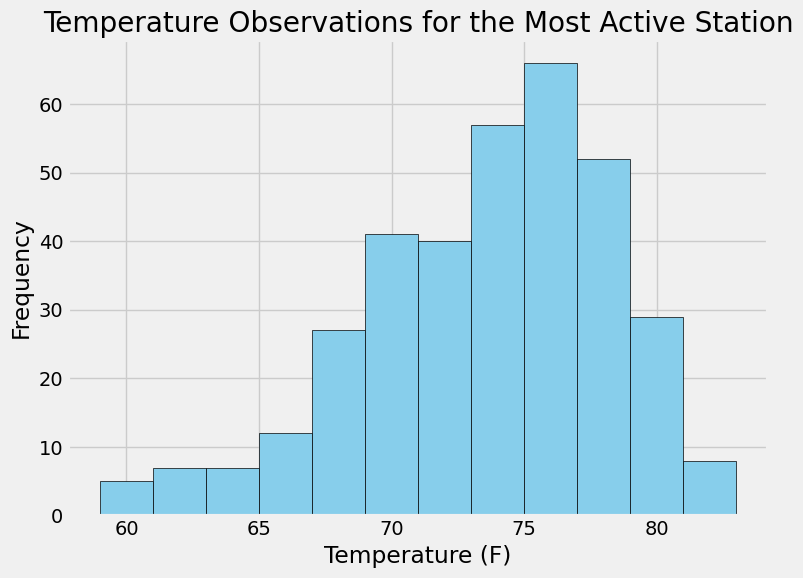

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = most_active_stations[0][0]  # Most active station is the first one in the list
previous_year_tobs = session.query(Measurement.tobs) \
                            .filter(Measurement.station == most_active_station) \
                            .filter(Measurement.date >= one_year_ago) \
                            .all()

# Convert the results to a list of temperatures
temperatures = [temp[0] for temp in previous_year_tobs]

# 4. Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, color='skyblue', edgecolor='black')
plt.title('Temperature Observations for the Most Active Station')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()